In [1]:
# Import necessary libraries
import os
from torchvision import datasets

In [2]:
# Load the dataset from the specified directory
dt = datasets.ImageFolder(root=r"C:\Users\vihan\projects\Dataset")

In [3]:
# Print the classes found in the dataset
print(dt.classes)

['beatroot', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'cheesecake', 'chicken curry', 'chicken_wings', 'dhal', 'french_fries', 'fried egg', 'fried_rice', 'ice_cream', 'kottu', 'milk rice', 'omelette', 'red_rice', 'sambol', 'white_rice']


In [4]:
# Print the number of classes in the dataset
print(len(dt.classes))

18


In [5]:
# Print the number of images in the dataset
print(len(dt))

9483


In [6]:
import torch
print(torch.cuda.is_available())

True


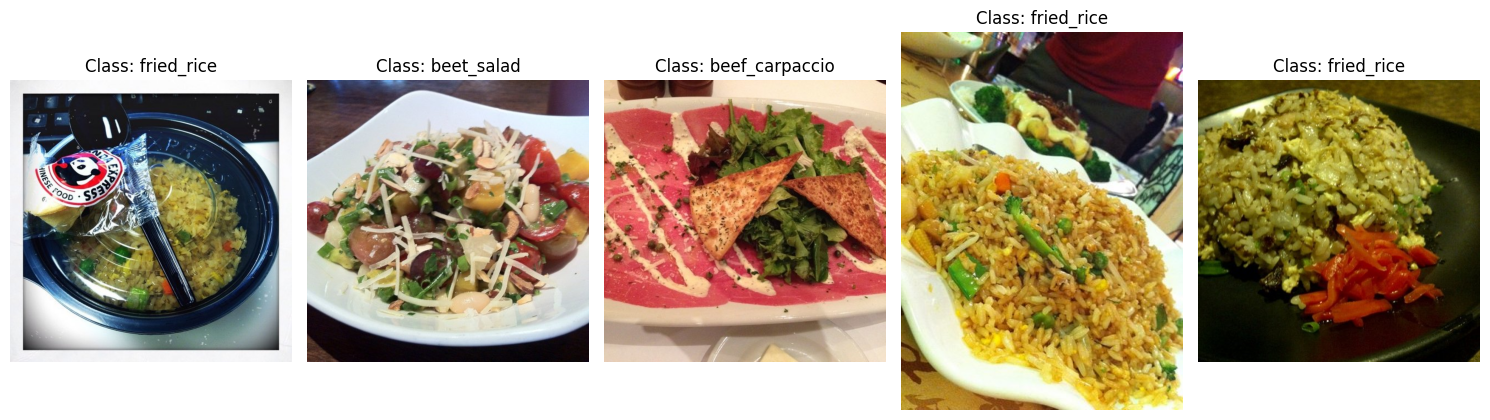

In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Define a transform to convert images to tensors 
transform = transforms.ToTensor()

# Pick some random indices
random_indices = random.sample(range(len(dt)), 5)  # show 5 random images

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, label = dt[idx]
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {dt.classes[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

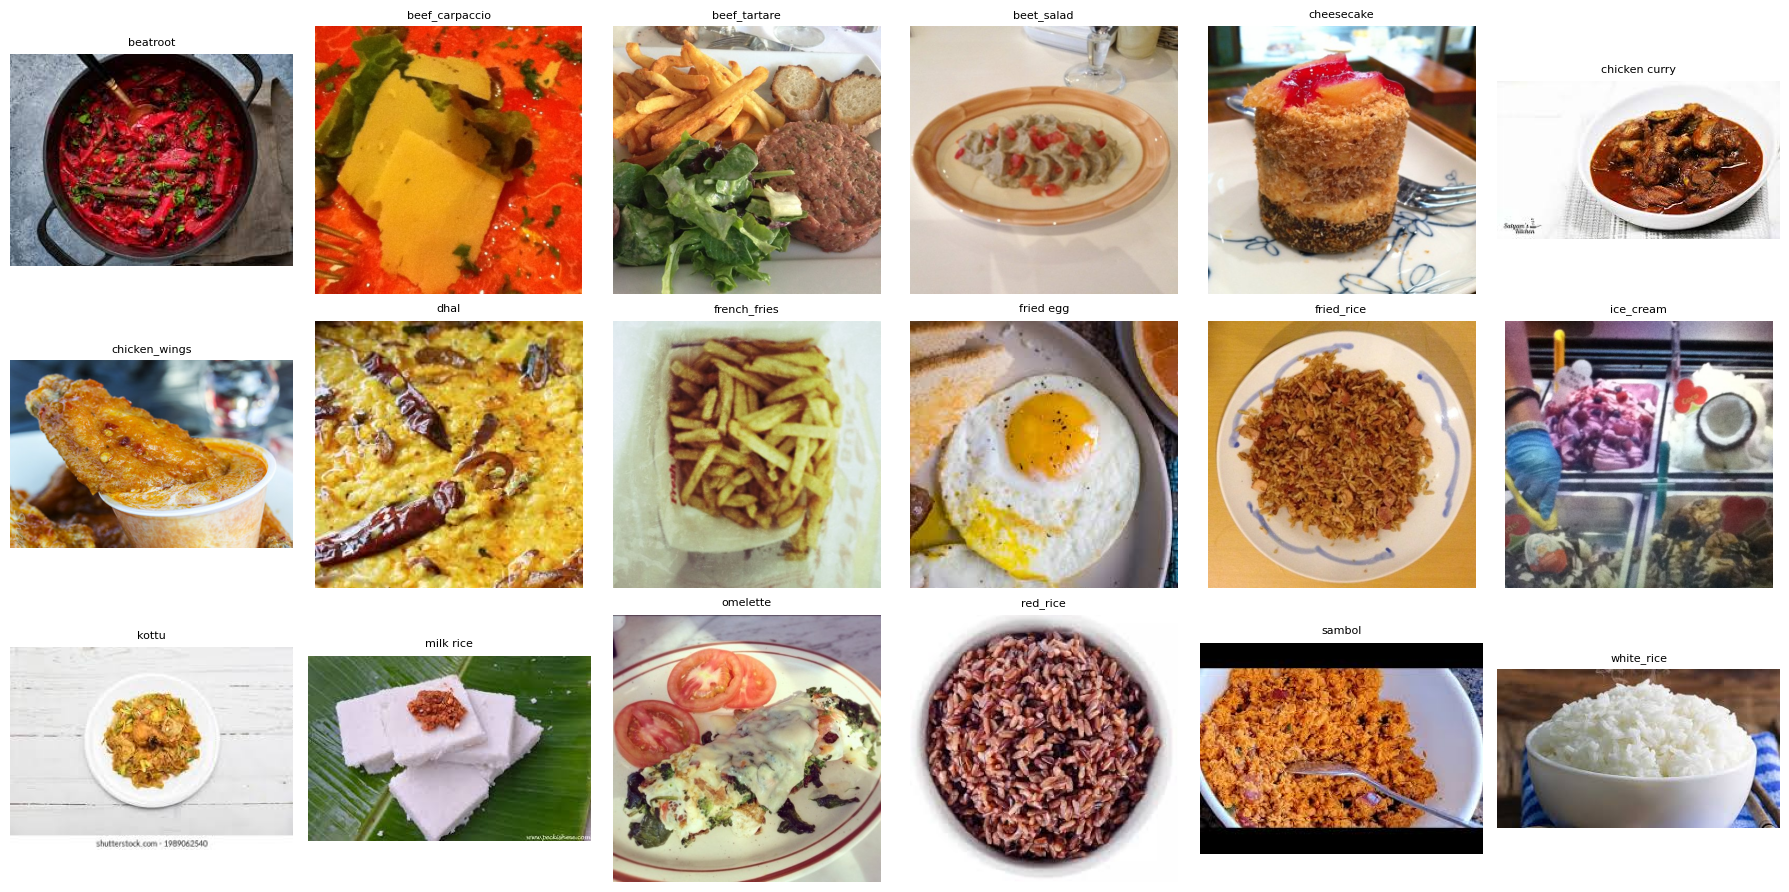

In [8]:
# Show one image per class
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Group indices by class
class_to_indices = {cls_idx: [] for cls_idx in range(len(dt.classes))}

for idx in range(len(dt)):
    _, label = dt[idx]
    class_to_indices[label].append(idx)

# Pick one random index per class
random_indices_per_class = [random.choice(indices) for cls_idx, indices in sorted(class_to_indices.items())]

# Set number of rows and columns 
num_classes = len(dt.classes)
num_cols = 6
num_rows = (num_classes + num_cols - 1) // num_cols  

plt.figure(figsize=(num_cols * 3, num_rows * 3))

for i, idx in enumerate(random_indices_per_class):
    image, label = dt[idx]
    
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)
    plt.title(f"{dt.classes[label]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


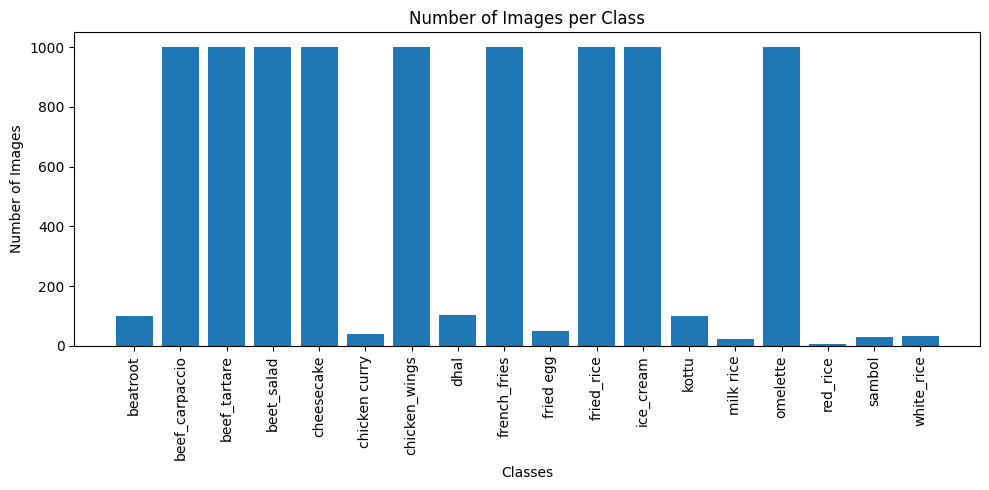

In [9]:
# Distribution of images per class
import matplotlib.pyplot as plt

class_counts = [len(indices) for indices in class_to_indices.values()]

plt.figure(figsize=(10,5))
plt.bar(dt.classes, class_counts)
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import time

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [12]:
# Load dataset and apply transformations
dataset = datasets.ImageFolder(root=r"C:\Users\vihan\projects\Dataset", transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

In [13]:
# Split into train & val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [14]:
# DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [15]:
# Pre-trained model
model = models.resnet18(pretrained=True)

C:\Users\vihan\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vihan\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# last layer for 18 classes
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [17]:
# Check if GPU is available and move model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [18]:
# Define the loss function for classification
criterion = nn.CrossEntropyLoss()
# Define the optimizer for model parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
import torch

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0  # Variable to track the best accuracy

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Save the best model as TorchScript
        if train_acc > best_acc:
            best_acc = train_acc
            model.eval()
            scripted_model = torch.jit.script(model)  # Script the model
            scripted_model.save('saved_model.pt')  # Save the TorchScript model
            print(f"Best model saved with accuracy: {best_acc:.4f}")

train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10, Loss: 1.1081, Accuracy: 0.6573
Best model saved with accuracy: 0.6573
Epoch 2/10, Loss: 0.7548, Accuracy: 0.7627
Best model saved with accuracy: 0.7627
Epoch 3/10, Loss: 0.6107, Accuracy: 0.8058
Best model saved with accuracy: 0.8058
Epoch 4/10, Loss: 0.5045, Accuracy: 0.8363
Best model saved with accuracy: 0.8363
Epoch 5/10, Loss: 0.4092, Accuracy: 0.8651
Best model saved with accuracy: 0.8651
Epoch 6/10, Loss: 0.4117, Accuracy: 0.8709
Best model saved with accuracy: 0.8709
Epoch 7/10, Loss: 0.3106, Accuracy: 0.8943
Best model saved with accuracy: 0.8943
Epoch 8/10, Loss: 0.2750, Accuracy: 0.9117
Best model saved with accuracy: 0.9117
Epoch 9/10, Loss: 0.3292, Accuracy: 0.8931
Epoch 10/10, Loss: 0.1899, Accuracy: 0.9392
Best model saved with accuracy: 0.9392


In [20]:
from PIL import Image

def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        print(f"Predicted Class: {class_names[pred.item()]}")

predict_image(r"C:\Users\vihan\Downloads\fried rice.jpg")

Predicted Class: dhal


In [21]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import os

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformation (adjust if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset only to get class names (not used for training here)
dataset = datasets.ImageFolder(root=r"C:\Users\vihan\projects\Dataset", transform=transform)
class_names = dataset.classes  # Get class names from folder structure

# Load the scripted model
model = torch.jit.load(r'C:\Users\vihan\projects\final-one\models-new\saved_model.pt')
model.eval()
model.to(device)

def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        print(f"Predicted Class: {class_names[pred.item()]}")

# Example usage
predict_image(r"C:\Users\vihan\Downloads\How To Cook Perfect Basmati Rice.jpg")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\vihan\\Downloads\\How To Cook Perfect Basmati Rice.jpg'

In [ ]:
import torch

# Load the scripted model
model = torch.jit.load('saved_model.pt')
model.eval()  # Set to evaluation mode

# Example: create a dummy input or use real data
from torchvision import transforms
from PIL import Image

# Load an image and preprocess (example)
image = Image.open(r"C:\Users\vihan\Downloads\dha.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to('cuda' if torch.cuda.is_available() else 'cpu')

# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    print("Predicted class:", predicted.item())


Predicted class: 11
